# Analysis of Movie Performance Data

This project analyzes movie budgets, revenue, ratings, and genres to uncover patterns that can guide better business and production decisions.

## Business Understanding
### Stakeholder

Our main stakeholders are film studio executives and production managers, who need reliable insights to guide investment, production, and release strategies.

### Business Problem

Your company wants to enter the movie industry by creating a new movie studio, but they currently lack experience in producing films. They need reliable insights about which types of movies are currently performing well at the box office, including information about genres, budgets, and audience ratings.

The goal is to identify high-profit genres, top-performing movies, and production strategies that maximize revenue while minimizing risk. This will allow the head of the new studio to make data-driven decisions on which movies to produce, how much to invest in production, and when to release them for the best chance of success.

### Key Questions

Which movie genres generate the highest profits?

Which movies have performed the best financially?

Do highly rated movies generate higher revenue?

How does production budget affect profit and revenue?

Does the release month affect movie ratings and performance?

## Importing and loading datasets

In [269]:
# importing libraries 
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



In [270]:
# load csv files
budgets = pd.read_csv("/Users/Maureen /Documents/Phase2-project/datasets/tn.movie_budgets.csv")
tmdb = pd.read_csv("/Users/Maureen /Documents/Phase2-project/datasets/tmdb.movies.csv")


# Connect to SQLite database
conn = sqlite3.connect("/Users/Maureen /Documents/Phase2-project/datasets/im.db")




## Data Overview

In [271]:
# Explore CSV

# Preview the first few rows
print(budgets.head())
print(tmdb.head())

# Check column names
print(budgets.columns)
print(tmdb.columns)

# Check basic info
print(budgets.info())
print(tmdb.info())

# Describe numeric columns
print(budgets.describe())
print(tmdb.describe())

# missing value 
print(budgets.isnull().sum())
print(tmdb.isnull().sum())


   id  release_date                                        movie  \
0   1  Dec 18, 2009                                       Avatar   
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides   
2   3   Jun 7, 2019                                 Dark Phoenix   
3   4   May 1, 2015                      Avengers: Age of Ultron   
4   5  Dec 15, 2017            Star Wars Ep. VIII: The Last Jedi   

  production_budget domestic_gross worldwide_gross  
0      $425,000,000   $760,507,625  $2,776,345,279  
1      $410,600,000   $241,063,875  $1,045,663,875  
2      $350,000,000    $42,762,350    $149,762,350  
3      $330,600,000   $459,005,868  $1,403,013,963  
4      $317,000,000   $620,181,382  $1,316,721,747  
   Unnamed: 0            genre_ids     id original_language  \
0           0      [12, 14, 10751]  12444                en   
1           1  [14, 12, 16, 10751]  10191                en   
2           2        [12, 28, 878]  10138                en   
3           3      [1

In [272]:
# Explore SQLite database

# All tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in database:", tables)

# Load IMDb tables
movie_basics = pd.read_sql("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings", conn)

conn.close()

Tables in database:             name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers
8   tmdb_budgets


In [273]:
print(budgets.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')


In [274]:
print(tmdb.columns)

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')


## Data cleaning 
Movie budgets dataset

In [275]:
# Remove $ and commas, then convert to integers
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budgets[col] = budgets[col].replace('[\$,]', '', regex=True).astype(int)

#Convert release_date to datetime
budgets['release_date'] = pd.to_datetime(budgets['release_date'])

# Check for duplicates
print("Number of duplicate rows:", budgets.duplicated().sum())

# Check for movies with 0 or negative budgets
invalid_budget = budgets[budgets['production_budget'] <= 0]
print("Invalid production budgets:\n", invalid_budget)

# Filter out invalid rows (budget <= 0 or negative gross)
budgets = budgets[(budgets['production_budget'] > 0) & 
                  (budgets['domestic_gross'] >= 0) & 
                  (budgets['worldwide_gross'] >= 0)]

Number of duplicate rows: 0
Invalid production budgets:
 Empty DataFrame
Columns: [id, release_date, movie, production_budget, domestic_gross, worldwide_gross]
Index: []


 TMDB dataset

In [276]:


# Drop duplicates
tmdb.drop_duplicates(inplace=True)

# Convert release_date to datetime
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'], errors='coerce')

# Drop rows with missing release_date or title
tmdb.dropna(subset=['title', 'release_date'], inplace=True)

# Extract release year for merging
tmdb['release_year'] = tmdb['release_date'].dt.year

# Drop unnecessary column
tmdb.drop(columns=['Unnamed: 0'], inplace=True)

# Keep only useful columns
tmdb = tmdb[['id', 'title', 'original_language', 'popularity', 
             'vote_average', 'vote_count', 'release_year', 'genre_ids']]


tmdb.head()


,id,title,original_language,popularity,vote_average,vote_count,release_year,genre_ids
0,12444,Harry Potter and the Deathly Hallows: Part 1,en,33.533,7.7,10788,2010,"[12, 14, 10751]"
1,10191,How to Train Your Dragon,en,28.734,7.7,7610,2010,"[14, 12, 16, 10751]"
2,10138,Iron Man 2,en,28.515,6.8,12368,2010,"[12, 28, 878]"
3,862,Toy Story,en,28.005,7.9,10174,1995,"[16, 35, 10751]"
4,27205,Inception,en,27.920,8.3,22186,2010,"[28, 878, 12]"


Merging

In [277]:
# Create release year from release_date
budgets['release_year'] = budgets['release_date'].dt.year

# Clean movie titles for merging
budgets['movie'] = budgets['movie'].str.strip().str.lower()
tmdb['title'] = tmdb['title'].str.strip().str.lower()


In [278]:
# Merge datasets
merged = pd.merge(
    budgets,
    tmdb,
    left_on=['movie', 'release_year'],  # merge on movie title and release year
    right_on=['title', 'release_year'],
    how='inner'           # keep movies present in both datasets
)
# Preview 
print("Merged dataset shape:", merged.shape)
merged.head()



Merged dataset shape: (1811, 14)


,id_x,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,id_y,title,original_language,popularity,vote_average,vote_count,genre_ids
0,1,2009-12-18,avatar,425000000,760507625,2776345279,2009,19995,avatar,en,26.526,7.4,18676,"[28, 12, 14, 878]"
1,2,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875,1045663875,2011,1865,pirates of the caribbean: on stranger tides,en,30.579,6.4,8571,"[12, 28, 14]"
2,4,2015-05-01,avengers: age of ultron,330600000,459005868,1403013963,2015,99861,avengers: age of ultron,en,44.383,7.3,13457,"[28, 12, 878]"
3,7,2018-04-27,avengers: infinity war,300000000,678815482,2048134200,2018,299536,avengers: infinity war,en,80.773,8.3,13948,"[12, 28, 14]"
4,9,2017-11-17,justice league,300000000,229024295,655945209,2017,141052,justice league,en,34.953,6.2,7510,"[28, 12, 14, 878]"


In [279]:
print(merged.columns)


Index(['id_x', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_year', 'id_y', 'title', 'original_language',
       'popularity', 'vote_average', 'vote_count', 'genre_ids'],
      dtype='object')


In [280]:
# remove rows which are identical
merged = merged.drop_duplicates(keep='first')


In [281]:
# remove duplicate columns and rename 
merged = merged.drop(columns=['id_y', 'title'])
merged = merged.rename(columns={'id_x': 'id'})


In [282]:
print(merged.columns)


Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_year', 'original_language', 'popularity',
       'vote_average', 'vote_count', 'genre_ids'],
      dtype='object')


In [283]:
genre_map = {
    28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime",
    99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History",
    27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance",
    878: "Science Fiction", 10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"
}


In [284]:
# Profit = worldwide gross minus budget
merged['profit'] = merged['worldwide_gross'] - merged['production_budget']

In [285]:
import ast

# Convert genre_ids from string to list
merged['genre_ids'] = merged['genre_ids'].apply(ast.literal_eval)

# Map genre IDs to readable genre names
merged['genres'] = merged['genre_ids'].apply(lambda x: [genre_map[i] for i in x])

print(merged[['genre_ids', 'genres']].head())



           genre_ids                                         genres
0  [28, 12, 14, 878]  [Action, Adventure, Fantasy, Science Fiction]
1       [12, 28, 14]                   [Adventure, Action, Fantasy]
2      [28, 12, 878]           [Action, Adventure, Science Fiction]
3       [12, 28, 14]                   [Adventure, Action, Fantasy]
4  [28, 12, 14, 878]  [Action, Adventure, Fantasy, Science Fiction]


In [286]:
# Explode genres so each row has one genre
df_exploded = merged.explode('genres')

# Group by genre and calculate mean profit
genre_profit = df_exploded.groupby('genres')['profit'].mean().sort_values(ascending=False)

print(genre_profit)


genres
Animation          2.778129e+08
Adventure          2.585759e+08
Fantasy            2.295800e+08
Family             2.084424e+08
Science Fiction    2.018695e+08
Action             1.670596e+08
Comedy             9.178872e+07
War                6.857375e+07
Thriller           6.362998e+07
Romance            6.142757e+07
Music              5.984200e+07
Mystery            5.911176e+07
Crime              5.718948e+07
Horror             5.036810e+07
Drama              4.994979e+07
Western            4.931515e+07
History            3.353324e+07
Documentary        1.836336e+07
TV Movie          -3.083333e+06
Name: profit, dtype: float64


## # Exploratory Data Analysis and Visualizations


In [287]:
merged.describe()
merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1658 entries, 0 to 1810
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1658 non-null   int64         
 1   release_date       1658 non-null   datetime64[ns]
 2   movie              1658 non-null   object        
 3   production_budget  1658 non-null   int64         
 4   domestic_gross     1658 non-null   int64         
 5   worldwide_gross    1658 non-null   int64         
 6   release_year       1658 non-null   int64         
 7   original_language  1658 non-null   object        
 8   popularity         1658 non-null   float64       
 9   vote_average       1658 non-null   float64       
 10  vote_count         1658 non-null   int64         
 11  genre_ids          1658 non-null   object        
 12  profit             1658 non-null   int64         
 13  genres             1658 non-null   object        
dtypes: datet

Which genres are the most profitable on average?

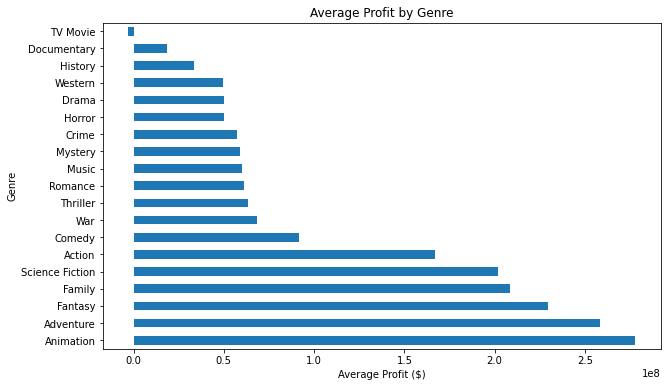

In [288]:

# Display and plot
genre_profit.plot(kind='barh', figsize=(10,6), title='Average Profit by Genre')
plt.xlabel('Average Profit ($)')
plt.ylabel('Genre')
plt.show()


### Genre profit insights

Animated and family movies make the most money since they attract wide audiences and sell plenty of merchandise.  
Action, comedy, and thriller films do fairly well too, while dramas, horror films, and TV movies tend to earn the least.


Do higher budgets lead to higher profits?

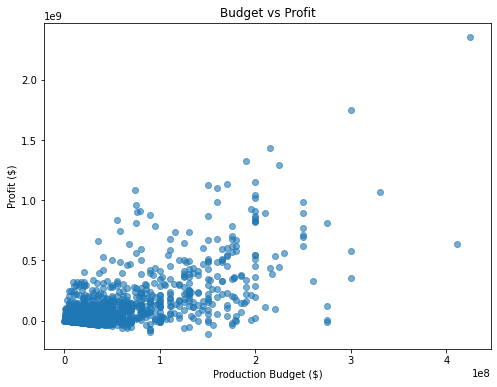

Correlation between budget and profit: 0.68
                              movie  production_budget      profit
0                            avatar          425000000  2351345279
3            avengers: infinity war          300000000  1748134200
25                   jurassic world          215000000  1433854864
51                        furious 7          190000000  1328722794
20                     the avengers          225000000  1292935897
29                    black panther          200000000  1148258224
85   jurassic world: fallen kingdom          170000000  1135772799
118                          frozen          150000000  1122469910
103            beauty and the beast          160000000  1099199706
336                         minions           74000000  1086336173


In [289]:
plt.figure(figsize=(8,6))
plt.scatter(merged['production_budget'], merged['profit'], alpha=0.6)
plt.title('Budget vs Profit')
plt.xlabel('Production Budget ($)')
plt.ylabel('Profit ($)')
plt.show()

# correlation value
corr = merged['production_budget'].corr(merged['profit'])
print(f"Correlation between budget and profit: {corr:.2f}")


top_profit = merged.sort_values('profit', ascending=False).head(10)
print(top_profit[['movie', 'production_budget', 'profit']])



How do profits trend over time?

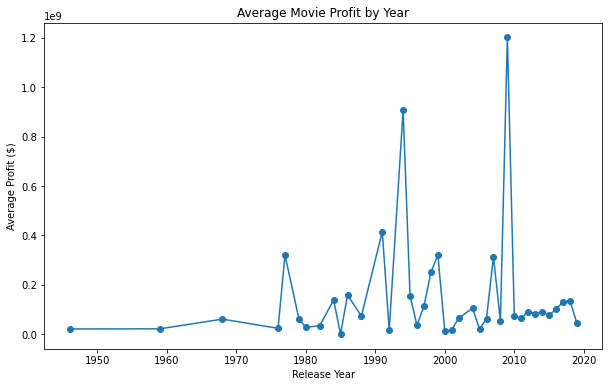

In [290]:
yearly_profit = merged.groupby('release_year')['profit'].mean()

plt.figure(figsize=(10,6))
plt.plot(yearly_profit, marker='o')
plt.title('Average Movie Profit by Year')
plt.xlabel('Release Year')
plt.ylabel('Average Profit ($)')
plt.show()


In [291]:
tmdb.columns


Index(['id', 'title', 'original_language', 'popularity', 'vote_average',
       'vote_count', 'release_year', 'genre_ids'],
      dtype='object')

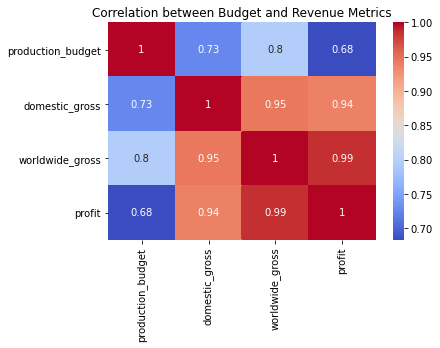

In [292]:

sns.heatmap(
    merged[['production_budget', 'domestic_gross', 'worldwide_gross', 'profit']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation between Budget and Revenue Metrics')
plt.show()


To find the genres that generates high income

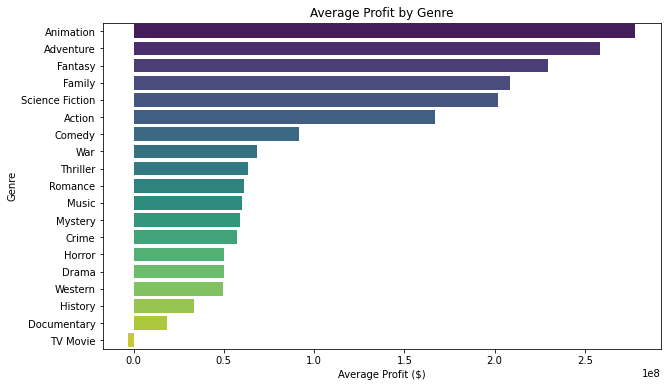

In [293]:
# Plot the average profit by genre
plt.figure(figsize=(10,6))
sns.barplot(x=genre_profit.values, y=genre_profit.index, palette="viridis")
plt.title('Average Profit by Genre')
plt.xlabel('Average Profit ($)')
plt.ylabel('Genre')
plt.show()


Movies in animation, adventure, fantancy and family genre generates high profits.
Invest more in Animation,family and fantasy,adventure films to maximize profitability and long-term brand engagement.


To find which movies performs best

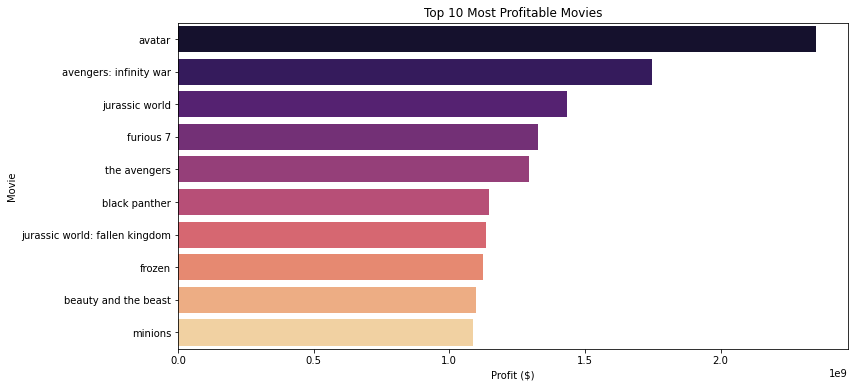

In [294]:
top_movies = merged.sort_values('profit', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='profit', y='movie', data=top_movies, palette="magma")
plt.title('Top 10 Most Profitable Movies')
plt.xlabel('Profit ($)')
plt.ylabel('Movie')
plt.show()

Big-budget movies like Avatar and Avengers make the most profit, especially in action, adventure, and fantasy genres. Studios should focus more on these types of movies for higher returns.

In [295]:
print(merged.columns)


Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_year', 'original_language', 'popularity',
       'vote_average', 'vote_count', 'genre_ids', 'profit', 'genres'],
      dtype='object')


In [296]:
merged.columns


Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_year', 'original_language', 'popularity',
       'vote_average', 'vote_count', 'genre_ids', 'profit', 'genres'],
      dtype='object')

Testing whether there’s a statistically significant correlation between a movie’s production budget and its profit

In [297]:

from scipy.stats import pearsonr

corr, p_value = pearsonr(merged['profit'], merged['production_budget'])
print(f"Correlation: {corr:.2f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    direction = "positive" if corr > 0 else "negative"
    print(f"Reject H₀: Significant {direction} correlation between budget and profit.")
else:
    print("Fail to reject H₀: No significant correlation between budget and profit.")


Correlation: 0.68
P-value: 0.0000
Reject H₀: Significant positive correlation between budget and profit.


There is a strong positive correlation (r = 0.68) between budget and profit, and it is highly significant (p ≈ 0). Higher budgets tend to yield higher profits.

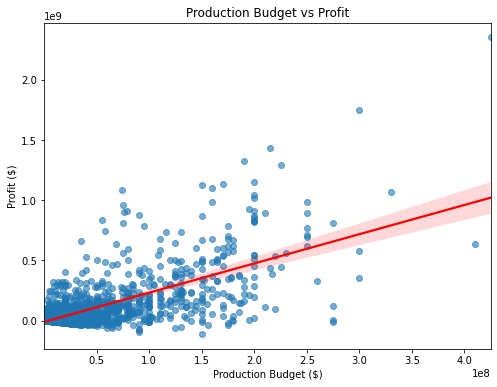

In [298]:


plt.figure(figsize=(8,6))
sns.regplot(
    data=merged,
    x='production_budget',
    y='profit',
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
plt.title('Production Budget vs Profit')
plt.xlabel('Production Budget ($)')
plt.ylabel('Profit ($)')
plt.show()


To find if the release month  affects the rating

Correlation between budget and profit: 0.68


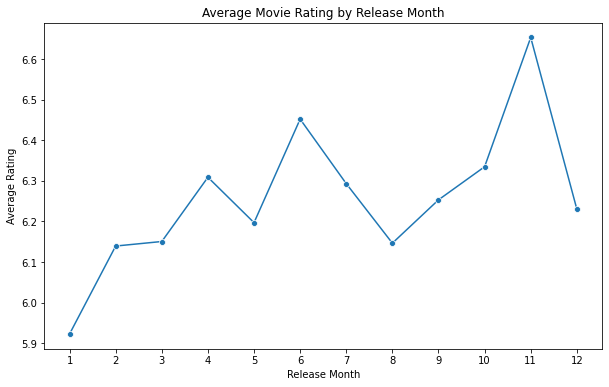

In [299]:
# Correlation
corr_budget_profit = merged['production_budget'].corr(merged['profit'])
print(f"Correlation between budget and profit: {corr_budget_profit:.2f}")

# Extract month
merged['release_month'] = merged['release_date'].dt.month

# Average rating per month
monthly_ratings = merged.groupby('release_month')['vote_average'].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_ratings.index, y=monthly_ratings.values, marker='o')
plt.title('Average Movie Rating by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Rating')
plt.xticks(range(1,13))
plt.show()

Movie realised in June And November have higher average ratings. Studios should consider releasing major films around these months to take advantage of audience interest and better reception

There is a strong positive correlation (0.68) between budget and profit.
This means that movies with higher budgets generally earn higher profits so investing more in production can lead to better financial performance.

To find the effect of production budget on profits ?revenue


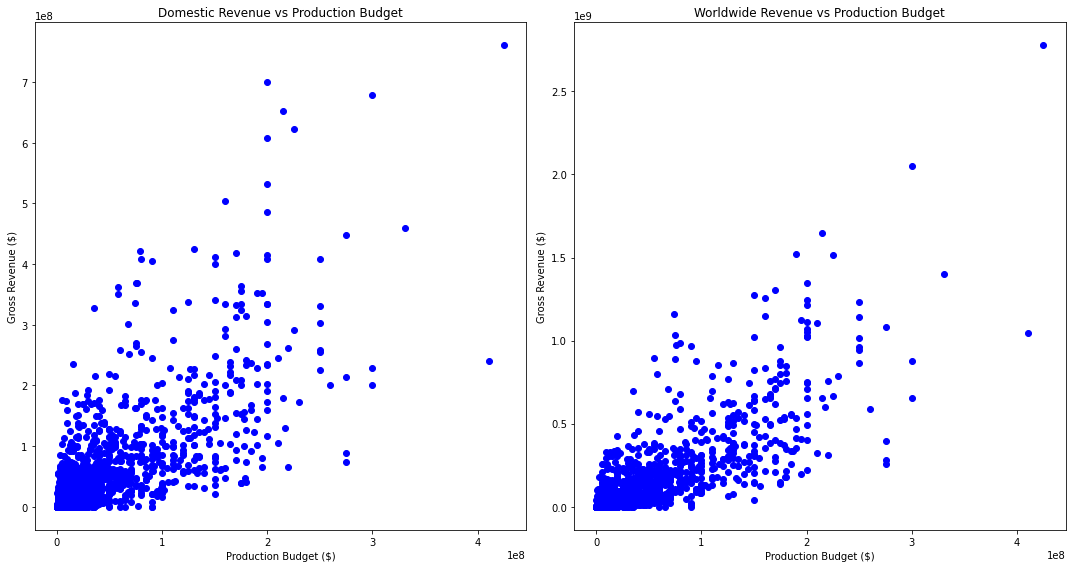

In [300]:
fig, ax = plt.subplots(ncols=2, figsize=(15,8))

ax[0].scatter(merged.production_budget, merged.domestic_gross, color='blue')
ax[1].scatter(merged.production_budget, merged.worldwide_gross, color='blue')

ax[0].set_title('Domestic Revenue vs Production Budget')
ax[1].set_title('Worldwide Revenue vs Production Budget')

for a in ax:
    a.set_xlabel('Production Budget ($)')
    a.set_ylabel('Gross Revenue ($)')

plt.tight_layout()
plt.show()
